In [1]:
!pip install fredapi > /dev/null

In [72]:
# "fdbb80cbd2c273c0fea0bc16a709e0d7"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import time

plt.style.use('fivethirtyeight')
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

from fredapi import Fred

fred_key = "fdbb80cbd2c273c0fea0bc16a709e0d7"

# 1. Create The Fred Object 

In [73]:
fred = Fred(api_key=fred_key)

# 2. Search for economic data!

In [74]:
sp_search = fred.search('S&P', order_by='popularity')

In [75]:
sp_search.head()

id realtime_start realtime_end  \
series id                                                    
BAMLH0A0HYM2      BAMLH0A0HYM2     2023-06-16   2023-06-16   
CSUSHPINSA          CSUSHPINSA     2023-06-16   2023-06-16   
BAMLH0A0HYM2EY  BAMLH0A0HYM2EY     2023-06-16   2023-06-16   
SP500                    SP500     2023-06-16   2023-06-16   
CSUSHPISA            CSUSHPISA     2023-06-16   2023-06-16   

                                                            title  \
series id                                                           
BAMLH0A0HYM2    ICE BofA US High Yield Index Option-Adjusted S...   
CSUSHPINSA        S&P/Case-Shiller U.S. National Home Price Index   
BAMLH0A0HYM2EY       ICE BofA US High Yield Index Effective Yield   
SP500                                                     S&P 500   
CSUSHPISA         S&P/Case-Shiller U.S. National Home Price Index   

               observation_start observation_end     frequency  \
series id                                                        
BAMLH0A0HYM2          1996-12-31      2023-06-15  Daily, Close   
CSUSHPINSA            1987-01-01      2023-03-01       Monthly   
BAMLH0A0HYM2EY        1996-12-31      2023-06-15  Daily, Close   
SP500                 2013-06-17      2023-06-15  Daily, Close   
CSUSHPISA             1987-01-01      2023-03-01       Monthly   

               frequency_short               units         units_short  \
series id                                                                
BAMLH0A0HYM2                 D             Percent                   %   
CSUSHPINSA                   M  Index Jan 2000=100  Index Jan 2000=100   
BAMLH0A0HYM2EY               D             Percent                   %   
SP500                        D               Index               Index   
CSUSHPISA                    M  Index Jan 2000=100  Index Jan 2000=100   

                    seasonal_adjustment seasonal_adjustment_short  \
series id                                                           
BAMLH0A0HYM2    Not Seasonally Adjusted                       NSA   
CSUSHPINSA      Not Seasonally Adjusted                       NSA   
BAMLH0A0HYM2EY  Not Seasonally Adjusted                       NSA   
SP500           Not Seasonally Adjusted                       NSA   
CSUSHPISA           Seasonally Adjusted                        SA   

                             last_updated popularity  \
series id                                              
BAMLH0A0HYM2    2023-06-16 09:11:07-05:00         95   
CSUSHPINSA      2023-05-30 09:01:01-05:00         90   
BAMLH0A0HYM2EY  2023-06-16 09:11:12-05:00         83   
SP500           2023-06-15 19:10:52-05:00         83   
CSUSHPISA       2023-05-30 09:01:04-05:00         81   

                                                            notes  
series id                                                          
BAMLH0A0HYM2    The ICE BofA Option-Adjusted Spreads (OASs) ar...  
CSUSHPINSA      For more information regarding the index, plea...  
BAMLH0A0HYM2EY  This data represents the effective yield of th...  
SP500           The observations for the S&P 500 represent the...  
CSUSHPISA       For more information regarding the index, plea...

# 3. Pull Raw Data and Plot

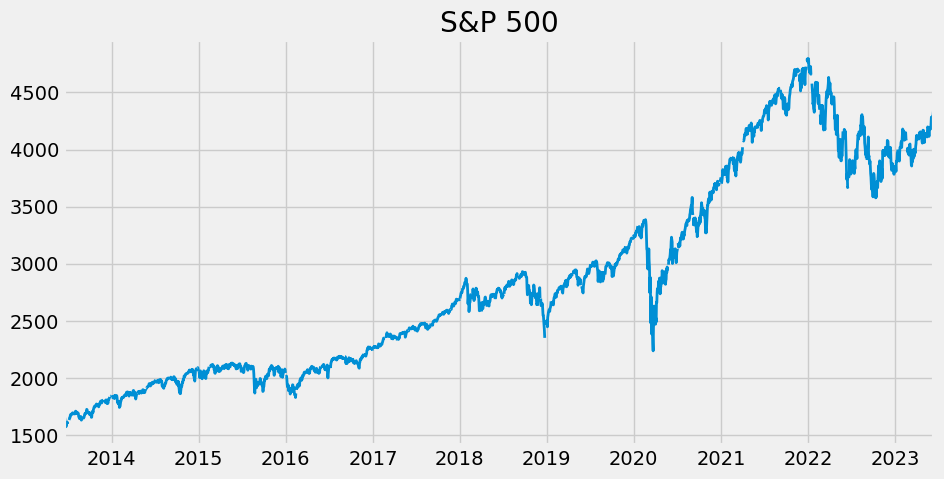

In [76]:
# sp500 series
sp500 = fred.get_series(series_id='SP500')
sp500.plot(figsize=(10, 5), title='S&P 500', lw=2)
plt.show()

# 4. Pull and Join Multiple Data Series

In [77]:
unemp_df = fred.search('unemployment rate state', filter=('frequency','Monthly'))
unemp_df = unemp_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
unemp_df = unemp_df.loc[unemp_df['title'].str.contains('Unemployment Rate')]

In [78]:
all_results = []

for myid in unemp_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
uemp_results = pd.concat(all_results, axis=1)

In [79]:
cols_to_drop = []
for i in uemp_results:
    if len(i) > 4:
        cols_to_drop.append(i)
uemp_results = uemp_results.drop(columns = cols_to_drop, axis=1)

In [80]:
uemp_states = uemp_results.copy()  #.drop('UNRATE', axis=1)
uemp_states = uemp_states.dropna()
id_to_state = unemp_df['title'].str.replace('Unemployment Rate in ','').to_dict()
uemp_states.columns = [id_to_state[c] for c in uemp_states.columns]

In [83]:
# Plot States Unemployment Rate
px.line(uemp_states)

# 5. Pull April 2020 Unemployment Rate Per State

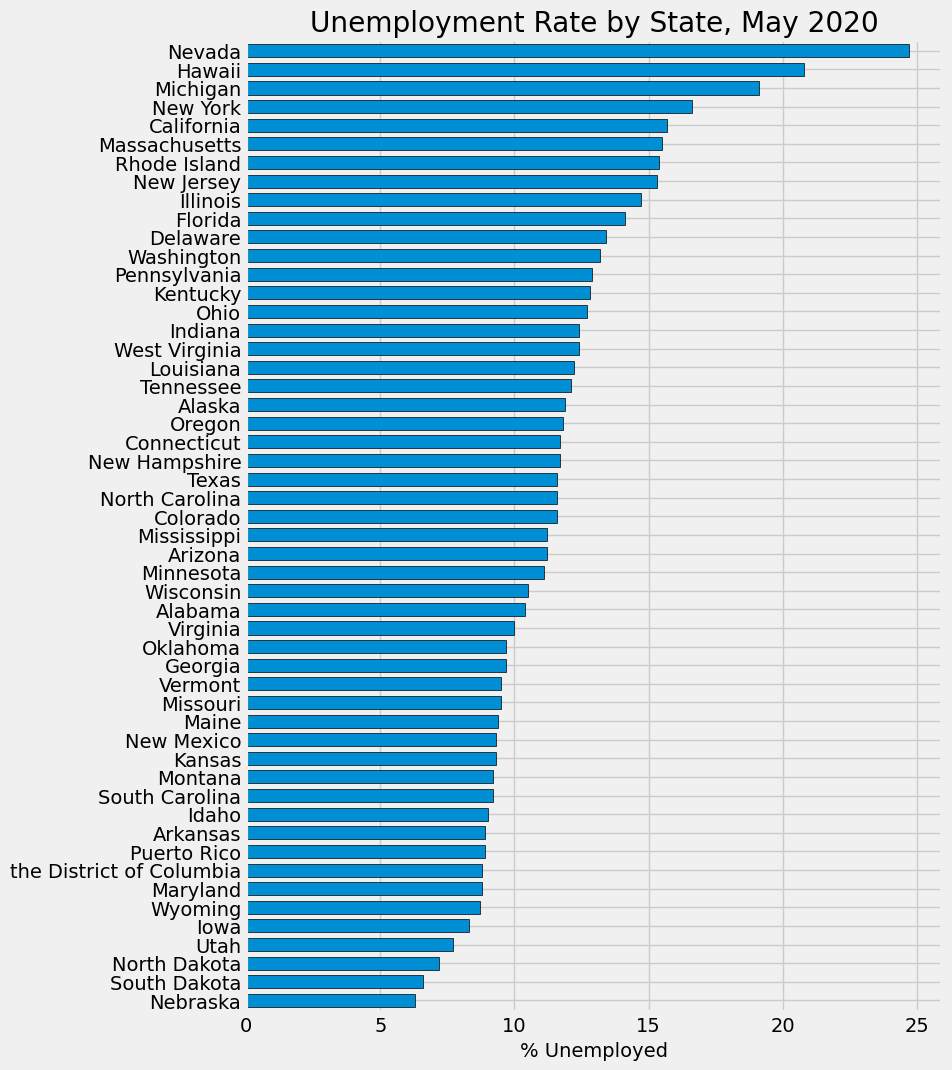

In [95]:
ax = uemp_states.loc[uemp_states.index == '2020-05-01'].T \
    .sort_values('2020-05-01') \
    .plot(kind='barh', figsize=(8, 12), width=0.7, edgecolor='black',
          title='Unemployment Rate by State, May 2020')
ax.legend().remove()
ax.set_xlabel('% Unemployed')
plt.show()

# 6. Pull Participation Rate

In [143]:
part_df = fred.search('participation rate state', filter=('frequency','Monthly'))
part_df = part_df.query('seasonal_adjustment == "Seasonally Adjusted" and units == "Percent"')
part_df = part_df.loc[part_df['title'].str.contains('Labor Force Participation Rate for')]

In [144]:
part_id_to_state = part_df['title'].str.replace('Labor Force Participation Rate for ','').to_dict()

all_results = []

for myid in part_df.index:
    results = fred.get_series(myid)
    results = results.to_frame(name=myid)
    all_results.append(results)
    time.sleep(0.1) # Don't request to fast and get blocked
part_states = pd.concat(all_results, axis=1)
part_states.columns = [part_id_to_state[c] for c in part_states.columns]

In [145]:
part_states.columns

Index(['California', 'Alabama', 'Minnesota', 'Florida', 'Wisconsin',
       'Kentucky', 'Michigan', 'Ohio', 'New York', 'Texas', 'Mississippi',
       'New Mexico', 'Iowa', 'Massachusetts', 'Maine', 'Tennessee', 'Georgia',
       'Indiana', 'Virginia', 'North Carolina', 'Illinois', 'Arizona',
       'Pennsylvania', 'New Hampshire', 'Colorado', 'Louisiana', 'Utah',
       'Oregon', 'West Virginia', 'Nevada', 'Maryland', 'Nebraska',
       'New Jersey', 'Vermont', 'Washington', 'Alaska', 'Connecticut',
       'South Carolina', 'Oklahoma', 'Montana', 'Missouri', 'Kansas',
       'Delaware', 'South Dakota', 'Arkansas', 'Hawaii', 'Wyoming', 'Idaho',
       'Rhode Island', 'North Dakota', 'District Of Columbia'],
      dtype='object')

# 7. Plot Unemployment vs Participation for each state!

In [146]:
# Fix DC
uemp_states = uemp_states.rename(columns={'the District of Columbia':'District Of Columbia'})

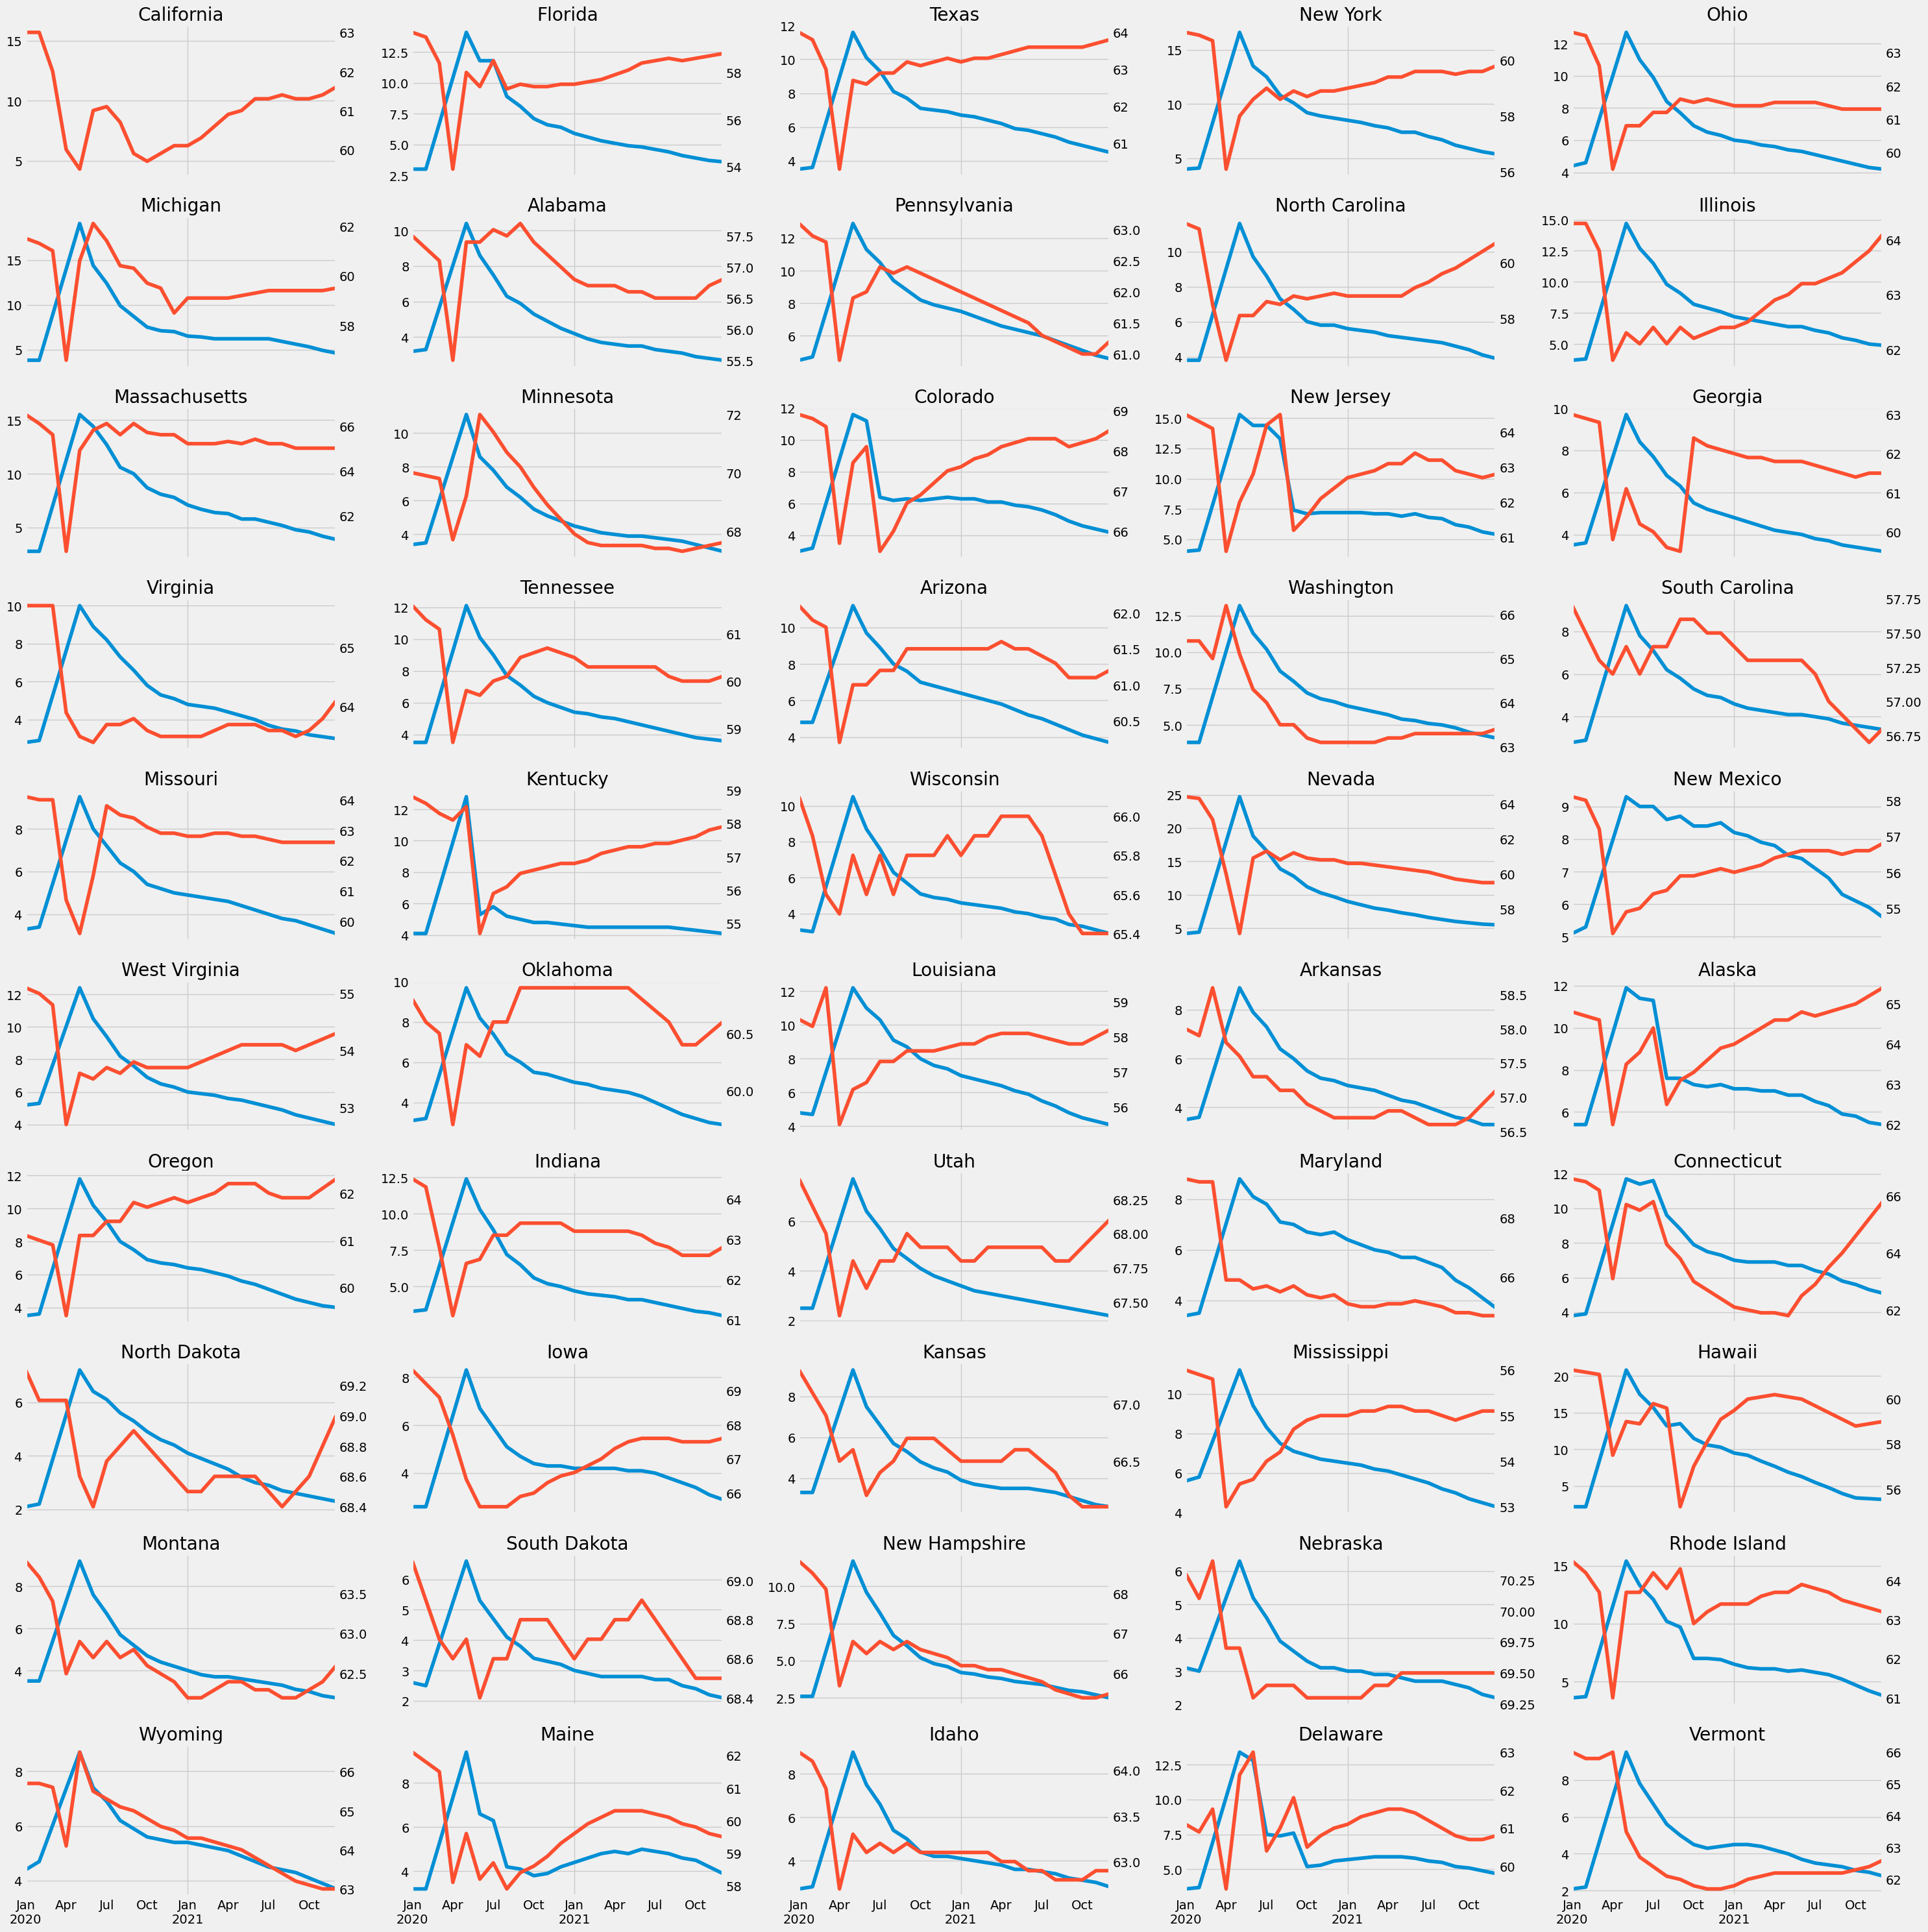

In [147]:
fig, axs = plt.subplots(10, 5, figsize=(30, 30), sharex=True)
axs = axs.flatten()

i = 0
for state in uemp_states.columns:
    if state in ["District Of Columbia","Puerto Rico"]:
        continue
    ax2 = axs[i].twinx()
    uemp_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=axs[i], label='Unemployment')
    part_states.query('index >= 2020 and index < 2022')[state] \
        .plot(ax=ax2, label='Participation', color=color_pal[1])
    ax2.grid(False)
    axs[i].set_title(state)
    i += 1
plt.tight_layout()
plt.show()